# Maksymilian Wojnar

# Analiza obwodu elektrycznego

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import numpy as np
import scipy.linalg
import time
import random
random.seed(1234)

Generator zwracający losowe grafy o wielkości około 20, 50 lub 200 wierzchołków typu:
 - Spójny graf losowy (Erdos-Renyi)
 - Graf 3-regularny (kubiczny)
 - Graf złożony z dwóch grafów losowych połaczonych mostkiem
 - Graf siatka 2D
 - Graf typu small-world

In [10]:
def random_graphs():
    # funkcja pomocnicza do generowania dwóch grafów losowych połaczonych mostkiem
    def double_random_graph(n):
        # wielkości grafów
        n1, n2 = (n + 1) // 2, n // 2
        
        # generowanie losowych grafów
        g1 = nx.erdos_renyi_graph(n1, 0.2)
        g2 = nx.erdos_renyi_graph(n2, 0.2)
        g2 = nx.relabel_nodes(g2, {i: i + n1 for i in range(n2)})
        
        # połączenie grafów mostkiem
        graph = nx.union(g1, g2)
        graph.add_edge(n1  // 2, n1  + n2 // 2)
        
        return graph
    
    # funkcja pomocnicza do generowania siatki 2D
    def grid_2d_graph(n):
        # siatka będzie miała rozmiar sqrt(n) x sqrt(n)
        n = int(np.sqrt(n))
        
        g = nx.grid_2d_graph(n, n)
        # przemianowanie wierzchołków z postaci krotki (i, j) na liczbę i * sqrt(n) + j
        g = nx.relabel_nodes(g, {(i, j): i * n + j for (i, j) in g})
        
        return g
    
    # funkcja pomocnicza do zapewnienia spójności grafu
    def make_connected(graph):
        to_connect = []
        
        # wyszukiwanie spójnych składowych
        for component in nx.connected_components(graph):
            to_connect.append(random.choice(tuple(component)))
            
        for u in to_connect:
            for v in to_connect:
                # połączenie ze sobą wszystkich spójnych składowych
                if u != v:
                    graph.add_edge(u, v)
                    
        return graph
    
    sizes = [20, 50, 200]
    types = [
        lambda n: nx.erdos_renyi_graph(n, 0.1),
        lambda n: nx.random_regular_graph(3, n),
        lambda n: double_random_graph(n),
        lambda n: grid_2d_graph(n),
        lambda n: nx.connected_watts_strogatz_graph(n, int(np.log2(n)), 0.5)
    ]
    
    for n in sizes:
        for func in types:
            # wygenerowanie losowego spójnego grafu danego typu i rozmiaru
            graph = make_connected(func(n))
            
            # nadanie losowych wag krawędzi (oporów) w zakresie od 10 do 100
            for u, v in graph.edges:
                graph[u][v]['weight'] = random.uniform(10, 100)
                
            yield graph

Metoda potencjałów węzłowych:

In [11]:
# funkcja pomocnicza, która na podstawie oryginalnego grafu oraz wartości potencjałów
# w wierzchołkach, generuje graf skierowany z natężeniami prądu na krawędziach
def circuit_from_voltage(graph, voltage):
    result = nx.DiGraph()
    
    for u, v in graph.edges:
        # dla każdej krawędzi wyznaczam natężenie prądu
        val = (voltage[u] - voltage[v]) / graph[u][v]['weight']
            
        if val > 1e-12:
            # jeśli jest dodatnie, to dodaję krawędź od u do v
            result.add_edge(u, v, weight=val)
        elif val < -1e-12:
            # jeśli jest ujemne, prąd płynie w przeciwnym kierunku (od v do u)
            result.add_edge(v, u, weight=-val)
        else:
            # jeśli jest bliskie zeru, to nie dodaję krawędzi, gdyż nie płynie przez nią prąd
            result.add_node(u)
            result.add_node(v)
                
    return result


# funkcja realizująca metodę potencjałów węzłowych
def node_analysis(graph, s, t, emf): 
    assert 0 <= s < len(graph)
    assert 0 <= t < len(graph)
    
    # zmienne w równaniu odpowiadają węzłom obwodu oraz źródłu zasilania
    n = len(graph) + 1
    matrix = np.zeros((n, n))
    
    # dodaję jedno równanie dla każdego wierzchołka
    for node in graph:
        # dla każdej krawędzi k wychodzącej z wierzchołka, dodaję składnik równania -U_k / R_k
        for edge, values in graph[node].items():
            matrix[node, edge] = -1 / values['weight']
            
        # ostatni składnik równania to U_node (1 / R_1 + ... + 1 / R_n)
        matrix[node, node] = np.sum([1 / values['weight'] for values in graph[node].values()])
        
    # w ostatnim wierszu oraz kolumnie dodaję źródło zasilania (wierzchołek s)
    matrix[-1, s] = 1
    matrix[s, -1] = 1
    
    # jako uziemienie wybieram drugie miejsce, w którym przyłożono SEM (wierzchołek t);
    # dzięki temu w ostatnim wierszu oraz kolumnie macierzy znajdzie się tylko jedna jedynka,
    # a wartości wszsytkich potencjałów w wierzchołkach będą nieujemne;
    # mógłbym pominąć tworzenie tego równania i z góry ustalić potencjał w wierzchołku t na 0,
    # lecz pozostawiam to równanie dla wygody, by móc łatwo odczytywać wyniki z wektora rozwiązań
    matrix[t, :] = 0
    matrix[:, t] = 0
    matrix[t, t] = 1
    
    # pierwszą część wektora wyrazów wolnych wypełniam zerami, gdyż nie ma w obwodzie dodatkowych źródeł prądu
    b = np.zeros(n)
    # w ostatniej komórce wprowadzam wartość napięcia w wierzchołku s
    b[-1] = emf
    
    x = np.linalg.solve(matrix, b)
    
    # wynik zwracam jako graf skierowany z wagami krawędzi odpowiadającymi natężeniu prądu
    return circuit_from_voltage(graph, x)

Metoda potencjałów węzłowych jest stosunkowo prosta, równania w tej metodzie możemy wyprowadzić z I prawa Kirchhofa. Jeden z wezłów obwodu oznaczamy jako uziemienie - dla uproszczenia w swojej implementacji wybrałem, aby był to wierzchołek $t$. W łatwy sposób możemy również dodać jedno (lub kilka) źródeł zasilania, w moim przypadku jest to wierzchołek $s$. Zaletą tej metody jest to, że otrzymujemy układ równań $n \times n$, gdzie $n$ to liczba węzłów w obwodzie / wierzchołków grafu, a więc liczba zmiennych w tej metodzie jest prawie zawsze mniejsza, niż przy korzystaniu z praw Kirchhoffa.

Wynikiem działania metody są potencjały w węzłach, zatem aby otrzymać natężenia prądu na krawędziach, należy posłużyć się prawem Ohma oraz napięciem pomiędzy sąsiednimi wierzchołkami. Natężenie na krawędzi $k$, która łączy wierzchołki $u$ i $v$, to $I_k = (U_u - U_v) / R_k$.

Rozwiązanie z wykorzystaniem I oraz II prawa Kirchhoffa:

In [12]:
# funkcja pomocnicza, która na podstawie oryginalnego grafu oraz wartości natężeń
# generuje graf skierowany z natężeniami prądu na krawędziach
def circuit_from_current(graph, current):
    result = nx.DiGraph()
    
    for u, v in graph.edges:
        # odczytanie numeru krawędzi, który odpowiada zmiennej w wektorze rozwiązań
        num = graph[u][v]['num']
        # w funkcji założyłem, że kierunek krawędzi to od mniejszego do większego wierzchołka
        u, v = min(u, v), max(u, v)
        # wartość natężenie na tej krawędzi
        val = current[num]
        
        if val > 1e-12:
            # jeśli natężenie jest dodatnie, to dodaję krawędź od u do v
            result.add_edge(u, v, weight=val)
        elif val < -1e-12:
            # jeśli jest ujemne, prąd płynie w przeciwnym kierunku (od v do u)
            result.add_edge(v, u, weight=-val)
        else:
            # jeśli jest bliskie zeru, to nie dodaję krawędzi, gdyż nie płynie przez nią prąd
            result.add_node(u)
            result.add_node(v)
                
    return result


# funkcja realizująca obliczenia w oparciu o I oraz II prawo Kirchhoffa
def kirchhoff(graph, s, t, emf):
    assert 0 <= s < len(graph)
    assert 0 <= t < len(graph)
    
    # dodaję sztuczny wierzchołek, który będzie "baterią" oraz krawędzie
    # od s do "baterii" oraz od "baterii" do t - ułatwi mi to układanie równań,
    # gdy s nie znajduje się w żadnym cyklu w grafie
    battery = max(graph.nodes) + 1
    graph.add_edge(battery, s, weight=0)
    graph.add_edge(t, battery, weight=0)
    
    # zmienne w równaniu odpowiadają połączeniom między węzłami 
    n = len(graph.edges)
    matrix = np.zeros((n, n))
    b = np.zeros(n)
    
    # nadaję krawędziom numery, które będą odpowiadać zmiennym w równaniach
    for i, edge in enumerate(graph.edges):
        graph[edge[0]][edge[1]]['num'] = i
        
    # numer obecnego równania
    i = 0
    
    # równania z I prawa Kirchhoffa
    for node in graph:
        # pomijam równanie dla wierzchołka s
        if node == s:
            continue
            
        for edge, values in graph[node].items():
            # wpisuję wartości 1 lub -1 zgodnie z ustalonym skierowaniem krawędzi,
            # a więc od mniejszego do większego wierzchołka
            matrix[i, graph[node][edge]['num']] = 1 if edge < node else -1
            
        i += 1
        
    # równania z II prawa Kirchhoffa
    for cycle in nx.cycle_basis(graph, battery):
        for j in range(-1, len(cycle) - 1):
            edge = graph[cycle[j]][cycle[j + 1]]
            
            # wpisuję wartości dodatnie lub ujemne zgodnie z ustalonym skierowaniem krawędzi
            if cycle[j] < cycle[j + 1]:
                matrix[i, edge['num']] = edge['weight']
            else:
                matrix[i, edge['num']] = -edge['weight']
                
        # jeśli w cyklu znajduje się "bateria", to w wektorze wyrazów wolnych wpisuję SEM
        if cycle[-1] == battery:
            b[i] = emf
                
        i += 1
    
    # usuwam dodatkowy wierzchołek (oraz tym samym dodatkowe krawędzie)
    graph.remove_node(battery)
    
    x = scipy.linalg.solve(matrix, b)
    return circuit_from_current(graph, x)

Przy rozwiązywaniu zadania z wykorzystaniem praw Kirchhoffa, zmienne będą odpowiadać połączeniom w obwodzie / krawędziom grafu, a więc prawie zawsze liczba zmiennych $m$ będzie większa, niż przy metodzie potencjałów węzłowych. Dodatkowym problemem jest to, iż prawa Kirchhoffa pozwalają niejednokrotnie na stworzenie większej liczby równań, niż liczba zmiennych, a więc otrzymujemy układ nadokreślony. Należy zauważyć zatem dwie własności:
 - I prawo Kirchhoffa pozwala na utworzenie $n$ (liczba węzłów) równań - po jednym dla każdego węzła. Możemy wykorzystać jednak tylko $n-1$ równań, gdyż równanie dla ostatniego węzła można zawsze otrzymać poprzez kombinację liniową pozostałych równań (jest zależne liniowo od pozostałych). Można to uzasadnić w następujący sposób - znając przepływy prądu we wszystkich węzłach, oprócz danego, możliwe jest obliczenie na tej podstawie przepływu w tym węźle. Aby nie tworzyć niepotrzebnie dodatkowego równania, w swoim rozwiązaniu pomijam równanie dla węzła $s$.
 - II prawo Kirchhoffa bazuje na wyszukiwaniu oczek w układzie. Okazuje się, iż prawie zawsze liczba wszystkich cykli + $n$ jest większa od liczby zmiennych, a więc od $m$. Należy jednak zwrócić uwagę, iż nie wszsytkie równania otrzymane z tego prawa będą liniowo niezależne, gdyż wyszukane cykle mogą być sumą innych cykli. Rozwiązaniem jest wyszukanie w grafie pewnej bazy cykli, która jest minimalnym zbiorem pozwalającym otrzymać wszystkie cykle w grafie za pomocą operacji unii i użycie tej bazy do utworzenia równań. W swojej metodzie realizuję wyszukiwanie przez funkcję cycle_basis z biblioteki NetworkX.

Po zastosowaniu w metodzie powyższych spostrzeżeń, otrzymujemy układ równań $m \times m$, a więc możliwe jest uniknięcie nadokreślonego układu.

Należy pamiętać również, że aby utworzyć równania z praw Kirchhoffa, powinniśmy nadać pewien kierunek prądu na krawędziach. W moim rozwiązaniu realizuję to przez następującą konwencję - w domyśle kierunek prądu to kierunek z wierzchołka o mniejszym numerze do wierzchołka o większym numerze. Jeśli w rozwiązaniu otrzymam ujemne natężenie, oznacza to że należy odwrócić kierunek prądu (z wierzchołka o większym numerze do wierzchołka o mniejszym numerze).

Funkcja do automatycznego sprawdzania poprawności rozwiązania; opiera się ona na sprawdzeniu czy suma prądów wchodzących oraz wychodzących z wierzchołka jest taka sama:

In [13]:
def test_graph(graph, s, t):
    nodes = {node: 0.0 for node in graph.nodes}
    
    for node in graph:
        for edge, values in graph[node].items():
            # dodaję wartość dla krawędzi wchodzącej
            nodes[node] += values['weight']
            # oraz odejmuję wartość dla krawędzi wychodzącej
            nodes[edge] -= values['weight']
            
    # dla wierzchołka s oraz t suma prądów wchodzących i wychodzących musi być równa 0
    if not np.isclose(nodes[s] + nodes[t], 0):
        return False
            
    # zeruję wartości dla wierzchołków, między którymi przyłożono SEM, gdyż
    # w tych punktach suma prądów wchodzących lub wychodzących musi być różna od 0
    nodes[s] = 0.0
    nodes[t] = 0.0
    
    # sprawdzam czy suma na wszystkich węzłach jest bliska 0
    return np.allclose(list(nodes.values()), np.zeros(len(nodes)))

Wizualizacja rozwiązania:

In [14]:
def print_graphs(graph, s, t, emf):
    def print_result(result, ax, method, pos=None):
        # krawędzie oraz natężenia prądu
        edges = nx.get_edge_attributes(result, 'weight').keys()
        weights = nx.get_edge_attributes(result, 'weight').values()
        
        # zwykłe wierzchołki są oznaczone na szaro, wierzchołek s na czerwono, t na niebiesko
        node_colors = {node: 'grey' for node in result.nodes}
        node_colors[s] = 'red'
        node_colors[t] = 'blue'
        node_colors = list(node_colors.values())
        
        # wierzchołki s oraz t są powiększone dla lepszej widoczności
        node_sizes = {node: 30 for node in result.nodes}
        node_sizes[s] = 70
        node_sizes[t] = 70
        node_sizes = list(node_sizes.values())
        
        if pos is None:
            # generuję pozycje wierzchołków tylko raz, aby grafy obok siebie były narysowane w ten sam sposób
            pos = nx.spring_layout(graph)
            
        # na grafie z praw Kirchhoffa rysuję dodatkowo etykiety z wartościami natężenia
        labels = {edge: float(f"{values:.2g}") for edge, values in nx.get_edge_attributes(result, 'weight').items()}
            
        nx.draw(result, pos, ax=ax, edge_color=weights, node_color=node_colors, node_size=node_sizes, edge_cmap=plt.cm.rainbow, width=2)
        nx.draw_networkx_edge_labels(result, pos, edge_labels=labels)
        ax.set_title(method)
        
        return pos
    
    # wyświetlam rozwiązania dla dówch metod obok siebie
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

    # metoda potencjałów węzłowych
    node_result = node_analysis(graph, s, t, emf)
    pos = print_result(node_result, axes[0], "Node analysis")

    # prawa Kirchhoffa
    kirchhoff_result = kirchhoff(graph, s, t, emf)
    print_result(kirchhoff_result, axes[1], "Kirchhoff's laws", pos)
    
    # wygenerowanie legendy dla kolorów krawędzi
    v_min = min(nx.get_edge_attributes(kirchhoff_result, 'weight').values())
    v_max = max(nx.get_edge_attributes(kirchhoff_result, 'weight').values())
    norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)
    cax = fig.add_axes([axes[1].get_position().x1 + 0.01, axes[1].get_position().y0 * 3, 0.005, axes[1].get_position().height / 2])
    
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='rainbow'), cax=cax)
    plt.show()
    
    return node_result, kirchhoff_result

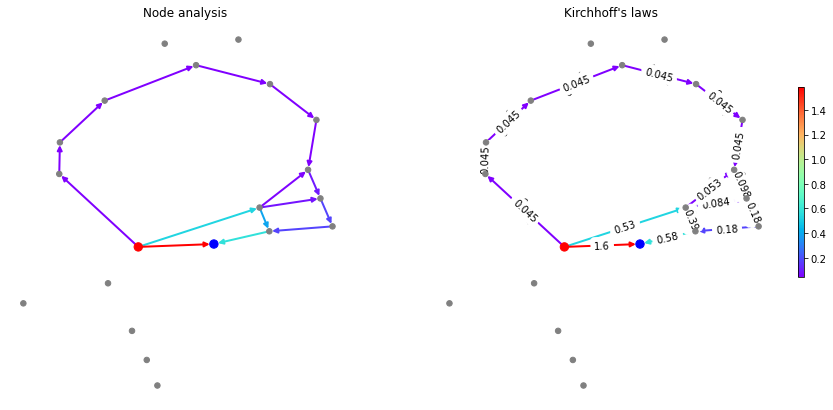

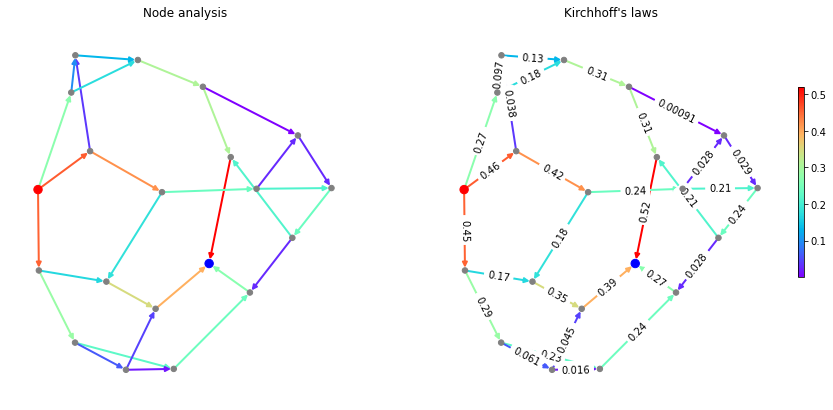

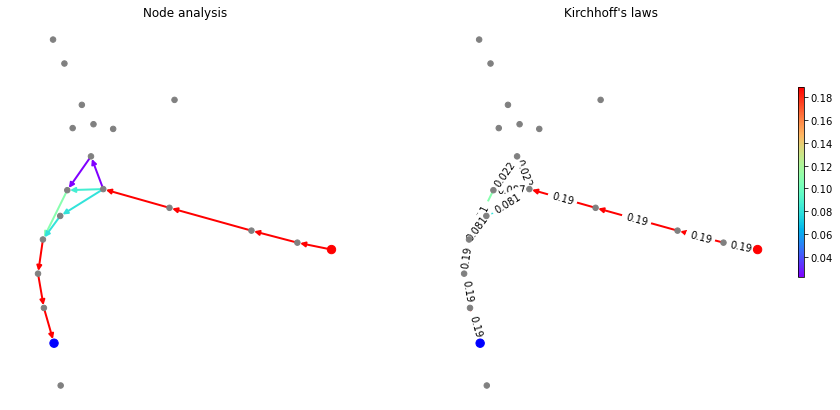

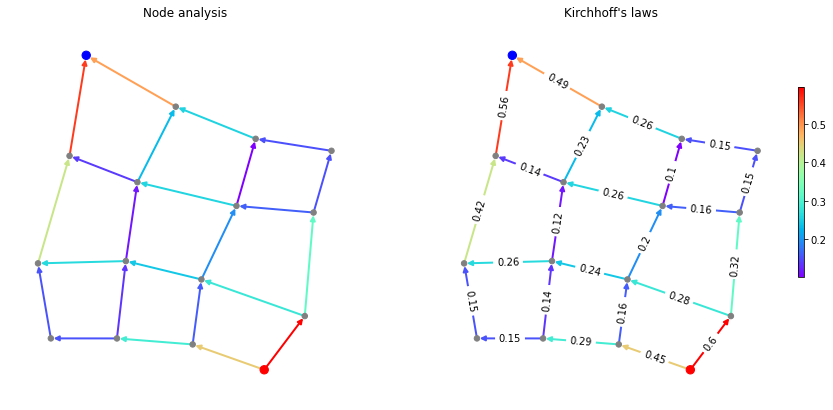

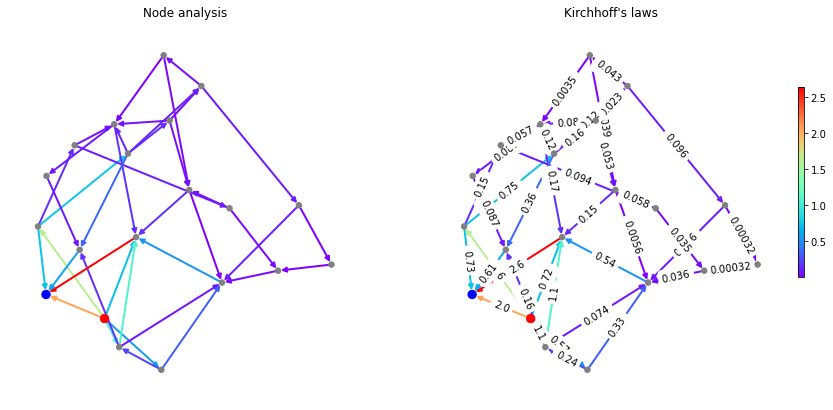

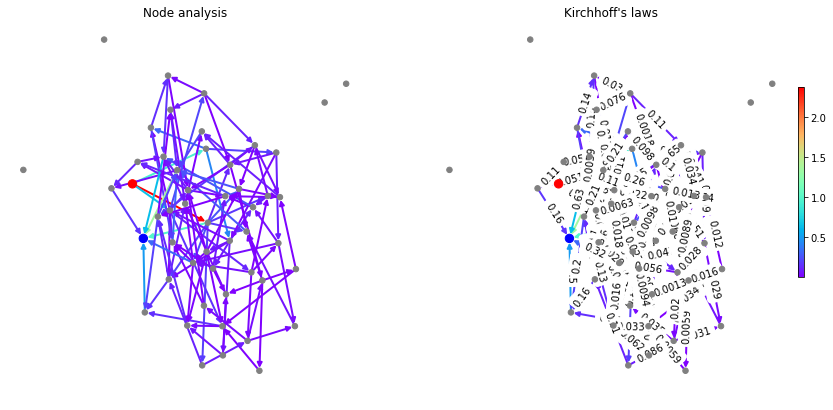

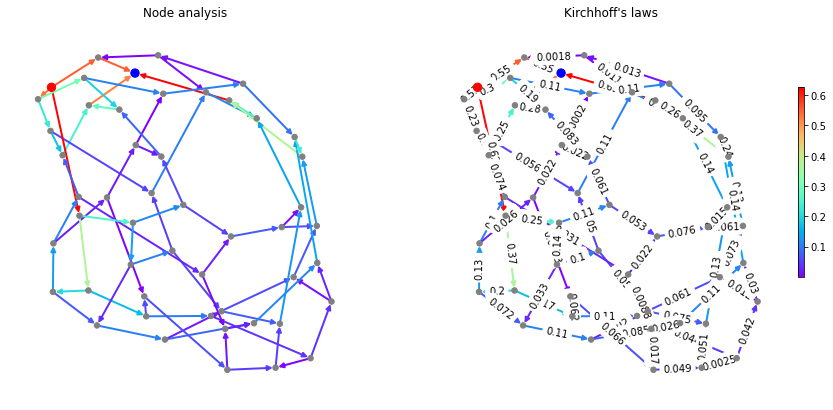

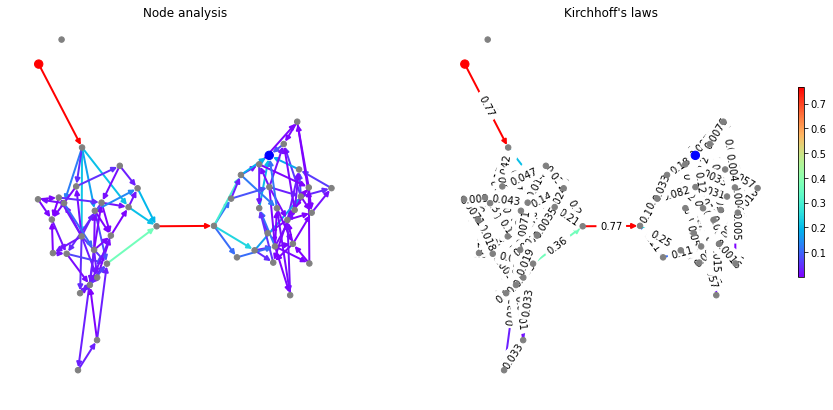

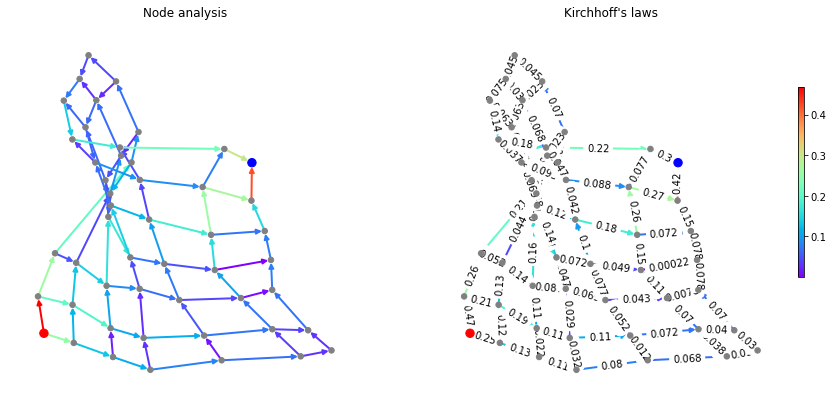

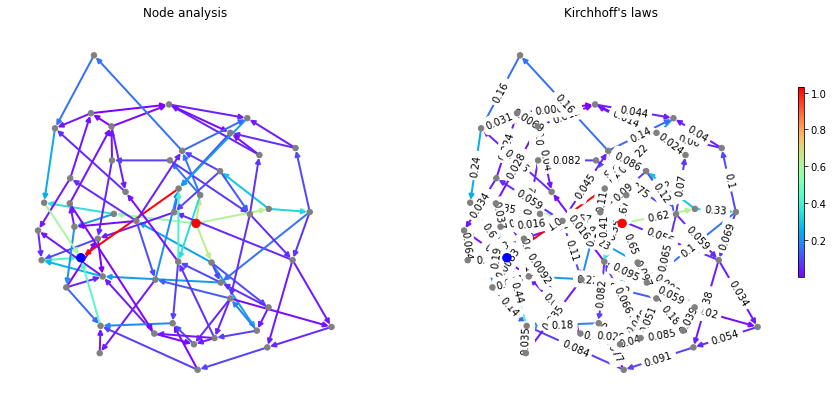

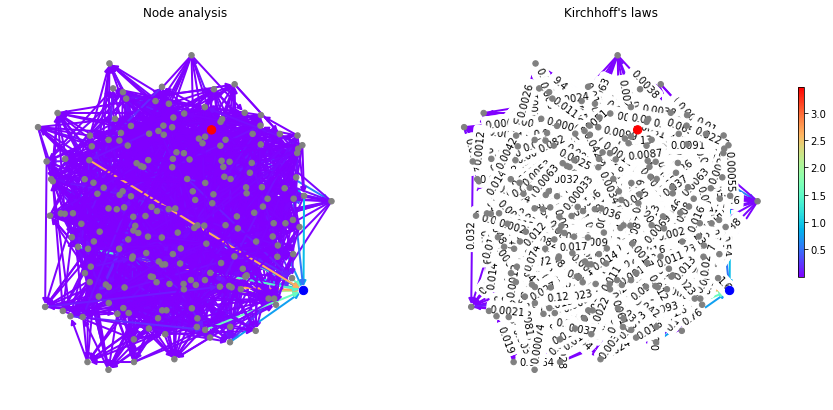

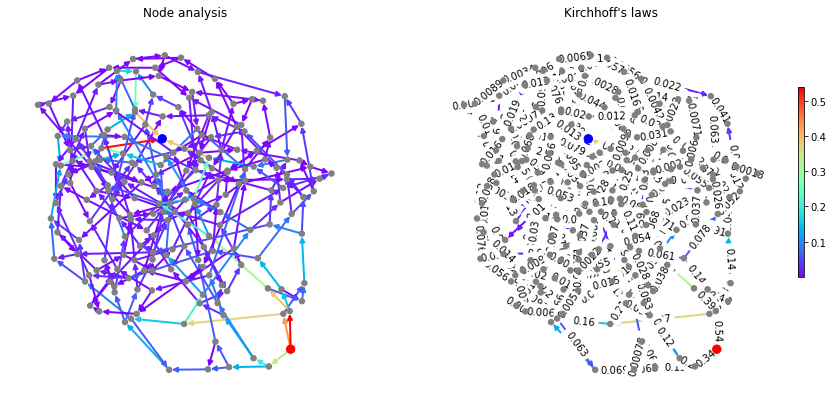

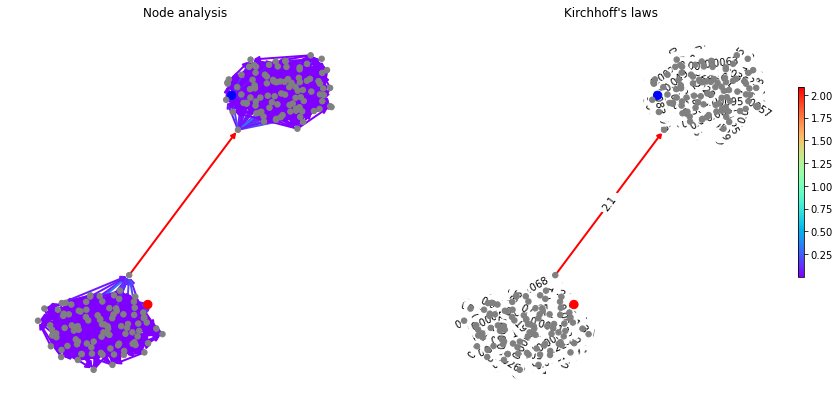

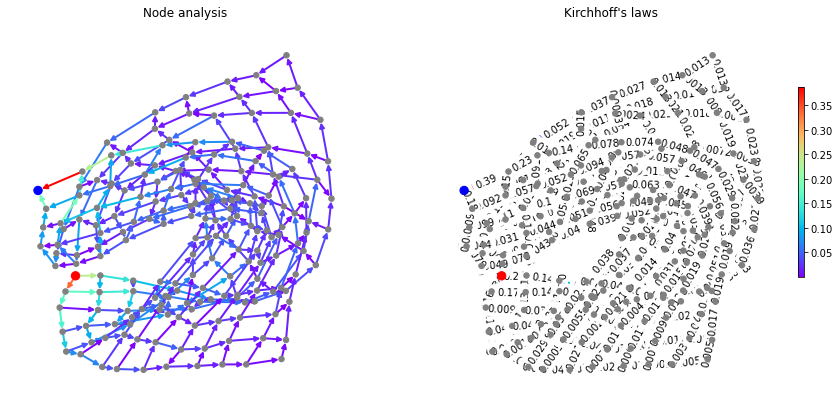

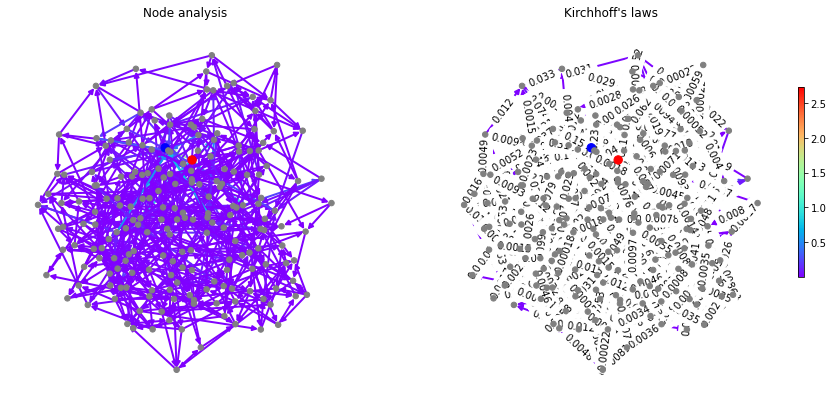

In [15]:
# dla każdego testowego grafu
for graph in random_graphs():
    # ustalam wierzchołki s oraz t jako pierwszy i ostatni w grafie, SEM = 100[V]
    s, t, emf = 0, len(graph) - 1, 100
    
    # rysowanie rozwiązania
    node_result, kirchhoff_result = print_graphs(graph, s, t, emf)
    
    # sprawdznie poprawności
    assert test_graph(node_result, s, t)
    assert test_graph(kirchhoff_result, s, t)

Prezentuję powyżej wizualizacje dla danych grafów testowych różnego rodzaju i wielkości. Po lewej są rozwiązania z wykorzystaniem metody potencjałów węzłowych, a po prawej z wykorzystaniem praw Kirchhoffa. Po prawej stronie dodałem również etykiety z wartością prądu na krawędziach (po lewej, dla czytelności, pominąłem etykiety). Kolory na krawędziach odpowiadają wielkości natężenia - obok wizualizacji znajduje się legenda dla kolorów. Wszystkie przypadki testowe przeszły pozytywnie test poprawności rozwiązania.

Program ma również możliwość wczytania z pliku własnego grafu reprezentującego pewien obwód, wygenerowania rozwiązania, narysowania go oraz sprawdzenia poprawności. Wierzchołki powinny być oznaczone kolejnymi liczbami naturalnymi od $0$ do $n-1$ ($n$ - liczba wierzchołków), natomiast krawędzie powinny być nieujemnymi liczbami zmiennoprzecinkowymi. Każda linia w pliku oznacza jedną krawędź w postaci "{wierzchołek 1} {wierzchołek 2} {waga krawędzi}".

In [16]:
def read_circuit_from_file(file_name):
    graph = nx.Graph()
    
    with open(file_name, "r") as file:
        lines = file.readlines()
        
        for line in lines:
            u, v, w = line.split()
            graph.add_edge(int(u), int(v), weight=float(w))
            
    return graph

In [ ]:
# dane do uzupełnienia
file_name = ''
s, t, emf = 0, 1, 100

# wczytanie grafu z pliku
graph = read_circuit_from_file(file_name)
# wyświetlenie obwodu
node_result, kirchhoff_result = print_graphs(graph, s, t, emf)
# test poprawności
assert test_graph(node_result, s, t)
assert test_graph(kirchhoff_result, s, t)